In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim

In [2]:

# Define transforms for data preprocessing
transform = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# DATA PREPARATION

name: tensor([[[[-1.2617, -1.4329, -1.2788,  ...,  1.8379,  0.9474,  0.9474],
          [-1.3644, -1.4329, -1.1932,  ...,  1.4612,  0.5878,  0.5707],
          [-1.5014, -1.4329, -1.1760,  ...,  1.1358,  0.3994,  0.5193],
          ...,
          [-1.5357, -1.5014, -1.5014,  ..., -0.0116,  0.0227,  0.0056],
          [-1.5014, -1.4843, -1.4672,  ...,  0.0227,  0.0227,  0.0227],
          [-1.5014, -1.4843, -1.5185,  ...,  0.0227,  0.0227,  0.0398]],

         [[-0.9328, -1.0553, -0.8627,  ...,  2.1134,  1.3081,  1.3256],
          [-1.0203, -1.0378, -0.7577,  ...,  1.7983,  0.9580,  0.9580],
          [-1.1253, -1.0028, -0.7227,  ...,  1.5182,  0.8004,  0.9405],
          ...,
          [-1.4230, -1.3880, -1.3704,  ...,  0.1352,  0.1702,  0.1352],
          [-1.3880, -1.3704, -1.3529,  ...,  0.1702,  0.1527,  0.1527],
          [-1.3880, -1.3704, -1.4055,  ...,  0.1702,  0.1527,  0.1702]],

         [[-1.4907, -1.5779, -1.4210,  ...,  1.8905,  0.6879,  0.6182],
          [-1.5256, -1.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


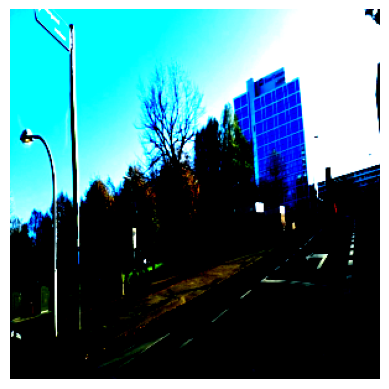

Class name for the selected image: garbage
0


In [3]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = self.load_images()

    def load_images(self):
        images = []
        for class_name in self.classes:
            class_dir = os.path.join(self.root_dir, class_name)
            for filename in os.listdir(class_dir):
                if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                    images.append((os.path.join(class_dir, filename), self.class_to_idx[class_name]))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


    def get_class_name(self, label):
        for cls, idx in self.class_to_idx.items():
            if idx == label:
                return cls
        return None


train_dataset = CustomImageDataset(root_dir=r"C:\Users\Dell\Downloads\final_rough2\train", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = CustomImageDataset(root_dir=r"C:\Users\Dell\Downloads\final_rough2\test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

for inputs, labels in train_loader:
    print('name:',inputs)
    print('label:',labels)
    batch_size, channels, height, width = inputs.size()
    print("Input batch dimensions:", batch_size, channels, height, width)
    print("Label batch dimensions:", labels.size())
    break  

for inputs, labels in train_loader:


    image = inputs[0] 

    image = np.transpose(image.numpy(), (1, 2, 0))

    plt.imshow(image)
    plt.axis('off')  
    plt.show()
    label_index = labels[0].item() 

    class_name = train_dataset.get_class_name(label_index)

    print("Class name for the selected image:", class_name)
    print(label_index)
    break 



# DENSENET201 

In [4]:
#***************************DENSENET201 ARCHITECTURE*********************************

class DenseNet(nn.Module):
    def __init__(self, num_classes):
        super(DenseNet, self).__init__()
        
        self.densenet = models.densenet201(pretrained=True)
        num_features = self.densenet.classifier.in_features
        
        self.densenet.classifier = nn.Linear(num_features, num_classes)
        print('features',num_features)

        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        return self.densenet(x)



#  model
model1 = DenseNet(num_classes=2)  #binary classification

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)


C:\Users\Dell\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


features 1920


In [149]:
#***********************************************DENSENET TRAINING*************************************
from torchvision.models import DenseNet
from tqdm import tqdm  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1.to(device) 

model1.train()
# Training loop
num_epochs = 5

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0


    # progress bar
    with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch + 1}/{num_epochs}") as tepoch:
        for inputs, labels in tepoch:
            optimizer.zero_grad()
            outputs = model1(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate loss
            running_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

            tepoch.set_postfix(loss=loss.item(), accuracy=correct_predictions / total_predictions)

    epoch_loss = running_loss / len(train_dataset)
    epoch_accuracy = correct_predictions / total_predictions

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss}, Accuracy: {epoch_accuracy}")

# Save
torch.save(model1.state_dict(), 'gcdn_net_adam.pth')


Epoch 1/5: 100%|████████████████████████████████████████| 47/47 [21:26<00:00, 27.38s/batch, accuracy=0.769, loss=0.399]


Epoch 1/5, Loss: 0.5021371427377065, Accuracy: 0.7693333333333333


Epoch 2/5: 100%|████████████████████████████████████████| 47/47 [20:23<00:00, 26.04s/batch, accuracy=0.798, loss=0.373]


Epoch 2/5, Loss: 0.4359377671877543, Accuracy: 0.798


Epoch 3/5: 100%|█████████████████████████████████████████| 47/47 [20:14<00:00, 25.84s/batch, accuracy=0.817, loss=0.49]


Epoch 3/5, Loss: 0.40011443535486857, Accuracy: 0.8166666666666667


Epoch 4/5: 100%|████████████████████████████████████████| 47/47 [20:18<00:00, 25.94s/batch, accuracy=0.837, loss=0.254]


Epoch 4/5, Loss: 0.3546101849079132, Accuracy: 0.8373333333333334


Epoch 5/5: 100%|████████████████████████████████████████| 47/47 [24:28<00:00, 31.25s/batch, accuracy=0.854, loss=0.211]


Epoch 5/5, Loss: 0.34010499795277915, Accuracy: 0.854


In [5]:

# Evaluation
def evaluate_model(model, dataloader, criterion):
    model.load_state_dict(torch.load('gcdn_net_adam.pth'))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            print(predicted)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions
    avg_loss = total_loss / total_predictions
    print(f"Test Accuracy: {accuracy:.4f}, Test Loss: {avg_loss:.4f}")

model = DenseNet(num_classes=2)  # Assuming binary classification

model.load_state_dict(torch.load('gcdn_net_adam.pth'))

# loss function
criterion = nn.CrossEntropyLoss()

evaluate_model(model1, test_loader, criterion)


features 1920
tensor([0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
        0, 1, 0, 1, 1, 1, 0, 0])
tensor([0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
        0, 1, 0, 0, 1, 1, 1, 1])
tensor([0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 0, 0, 1, 0, 1, 1, 0])
tensor([1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 1, 0, 0, 1, 1, 1])
tensor([0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
        1, 0, 1, 1, 1, 0, 0, 0])
tensor([1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 1])
tensor([0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
        0, 1, 1, 1, 1, 1, 0, 1])
tensor([0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 0, 0])
tensor([1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
  

tensor([[[[ 2.2489,  2.2489,  2.2489,  ..., -0.5938, -0.5938, -0.2513],
          [ 2.2489,  2.2489,  2.2489,  ..., -0.1999, -0.4739, -0.3369],
          [ 2.2489,  2.2489,  2.2489,  ..., -0.6109, -0.6794, -0.2342],
          ...,
          [-0.2342, -0.2513, -0.2171,  ...,  1.6153,  1.6495,  1.6495],
          [-0.2171, -0.2513, -0.2171,  ...,  1.6324,  1.6495,  1.6324],
          [-0.2171, -0.2513, -0.2342,  ...,  1.6495,  1.6153,  1.6495]],

         [[ 2.4286,  2.4286,  2.4286,  ..., -0.4601, -0.4776, -0.1275],
          [ 2.4286,  2.4286,  2.4286,  ..., -0.0749, -0.3550, -0.2150],
          [ 2.4286,  2.4286,  2.4286,  ..., -0.5126, -0.5476, -0.0924],
          ...,
          [-0.0399, -0.0399, -0.0049,  ...,  1.8508,  1.8859,  1.8859],
          [-0.0399, -0.0574, -0.0049,  ...,  1.8508,  1.8859,  1.8683],
          [-0.0574, -0.0574, -0.0224,  ...,  1.8333,  1.8508,  1.8859]],

         [[ 2.6400,  2.6400,  2.6400,  ..., -0.3055, -0.2881,  0.0605],
          [ 2.6400,  2.6400,  

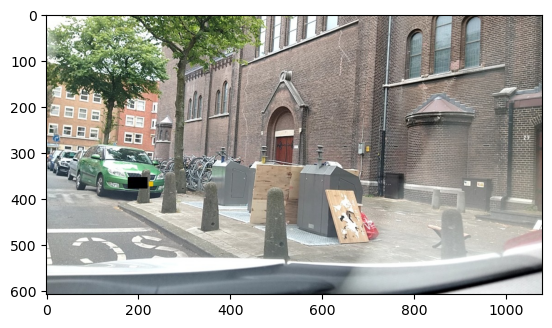

In [6]:
def evaluate_image1(model, image_path, transform):
    model.load_state_dict(torch.load('gcdn_net_adam.pth'))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # Preprocess
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    print(image_tensor)
    plt.imshow(image)
    with torch.no_grad():
        outputs = model(image_tensor)

    _, predicted_idx = torch.max(outputs, 1)
    predicted_idx = predicted_idx.item()  # Extract the index value from the tensor
    print(predicted_idx)
    
    class_names = ['garbage', 'nongarbarge']  
    predicted_class = class_names[predicted_idx]

    return predicted_class

#input 
image_path = r"C:\Users\Dell\Downloads\basxcxe\30.jpg"
predicted_class = evaluate_image1(model1, image_path, transform)
print(f"Predicted Class: {predicted_class}")


# INCEPTIONV3

In [23]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
class Inceptionv3Net(nn.Module):
    def __init__(self, num_classes):
        super(Inceptionv3Net, self).__init__()
        self.densenet = models.densenet201(pretrained=True)
        self.inception = models.inception_v3(pretrained=True, aux_logits=True)

        num_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_features, num_classes)
        print('features',num_features)
        num_features_inception = self.inception.fc.in_features
        self.inception.fc = nn.Linear(num_features_inception, num_classes)
        print('features',num_features_inception)

        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        return self.inception(x)

#model creation
modeli = Inceptionv3Net(num_classes=2)  # Assuming binary classification

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modeli.parameters(), lr=0.001)


C:\Users\Dell\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


features 1920
features 2048


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from tqdm import tqdm


optimizer = optim.Adam(modeli.parameters(), lr=0.0001)  

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    modeli.train()

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs, aux_outputs = modeli(inputs)  # Extracting logits
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)  # Auxiliary loss
            loss = loss1 + 0.4 * loss2  # Combined loss
            loss.backward()
            optimizer.step()

            # Calculate loss
            running_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

            pbar.set_postfix({'loss': running_loss / total_predictions, 'accuracy': correct_predictions / total_predictions})
            pbar.update()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_predictions / len(train_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, Accuracy: {epoch_accuracy}")

# Save the model
torch.save(modeli.state_dict(), 'inceptionv3_model.pth')


Epoch 1/5: 100%|█████████████████████████████████████████| 47/47 [15:23<00:00, 19.66s/batch, loss=1.96, accuracy=0.783]


Epoch 1/5, Loss: 1.9597863629659016, Accuracy: 0.7826666666666666


Epoch 2/5: 100%|████████████████████████████████████████| 47/47 [10:22<00:00, 13.25s/batch, loss=0.427, accuracy=0.937]


Epoch 2/5, Loss: 0.42707998657226565, Accuracy: 0.9373333333333334


Epoch 3/5: 100%|████████████████████████████████████████| 47/47 [10:29<00:00, 13.39s/batch, loss=0.0795, accuracy=0.99]


Epoch 3/5, Loss: 0.07947632693747679, Accuracy: 0.99


Epoch 4/5: 100%|███████████████████████████████████████| 47/47 [10:32<00:00, 13.45s/batch, loss=0.0247, accuracy=0.997]


Epoch 4/5, Loss: 0.024718200740714867, Accuracy: 0.9966666666666667


Epoch 5/5: 100%|███████████████████████████████████████| 47/47 [10:34<00:00, 13.50s/batch, loss=0.0202, accuracy=0.997]


Epoch 5/5, Loss: 0.02016995752354463, Accuracy: 0.9966666666666667


In [5]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from tqdm import tqdm

modeli.load_state_dict(torch.load('inceptionv3_model.pth'))


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modeli.to(device)

modeli.eval()


correct_predictions = 0
total_predictions = 0
total_loss = 0.0
criterion = nn.CrossEntropyLoss()


transform = transforms.Compose([
    transforms.Resize((299, 299)),  
    transforms.ToTensor(),         
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])


with torch.no_grad():

    with tqdm(total=len(test_loader), desc='Test', unit='batch') as pbar:
        for inputs, labels in test_loader:
            outputs = modeli(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
            pbar.update()

#accuracy and average loss
accuracy = correct_predictions / len(test_loader.dataset)
average_loss = total_loss / len(test_loader.dataset)

print(f"Accuracy on test set: {accuracy}")
print(f"Average loss on test set: {average_loss}")


Test: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [01:05<00:00,  6.50s/batch]

Accuracy on test set: 0.7366666666666667
Average loss on test set: 0.9925164715449015


# GCDN NET 

In [4]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

class CombinedModel(nn.Module):
    def __init__(self, num_classes):
        super(CombinedModel, self).__init__()
        self.densenet = models.densenet201(pretrained=True)
        self.inception = models.inception_v3(pretrained=True, aux_logits=True)

        num_features_densenet = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_features_densenet, num_classes)

        num_features_inception = self.inception.fc.in_features
        self.inception.fc = nn.Linear(num_features_inception, num_classes)


        self.fc_combined = nn.Linear(num_classes * 2, num_classes)  # Concatenating 

        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        output_densenet = self.densenet(x)
        output_inception,_= self.inception(x)  # Extracting main and auxiliary outputs from InceptionV3

        # Check if the spatial dimensions of output_inception match output_densenet
        if output_densenet.shape[-2:] != output_inception.shape[-2:]:
    
            output_inception = torch.nn.functional.interpolate(output_inception, size=output_densenet.shape[-2:])

        # Combining outputs
        combined_output = torch.cat((output_densenet, output_inception), dim=1)
        output = self.fc_combined(combined_output)
        return self.log_softmax(output)







# model
combined_model = CombinedModel(num_classes=2)

#loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(combined_model.parameters(), lr=0.001)
print("finished")


C:\Users\Dell\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Dell\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the 

finished


In [7]:
import torch
from tqdm import tqdm

num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    combined_model.to(device)
    combined_model.train()

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = combined_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate loss
            running_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

            pbar.set_postfix({'loss': running_loss / total_predictions, 'accuracy': correct_predictions / total_predictions})
            pbar.update()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_predictions / len(train_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, Accuracy: {epoch_accuracy}")

# Save the model
torch.save(combined_model.state_dict(), 'combined_model.pth')


Epoch 1/5: 100%|███████████████████████████████████████| 47/47 [1:02:18<00:00, 79.54s/batch, loss=0.51, accuracy=0.779]


Epoch 1/5, Loss: 0.5102008511225382, Accuracy: 0.7786666666666666


Epoch 2/5: 100%|████████████████████████████████████████| 47/47 [54:33<00:00, 69.64s/batch, loss=0.418, accuracy=0.814]


Epoch 2/5, Loss: 0.41750139276186626, Accuracy: 0.814


Epoch 3/5: 100%|█████████████████████████████████████████| 47/47 [51:10<00:00, 65.34s/batch, loss=0.38, accuracy=0.837]


Epoch 3/5, Loss: 0.3800012260278066, Accuracy: 0.8366666666666667


Epoch 4/5: 100%|████████████████████████████████████████| 47/47 [46:40<00:00, 59.59s/batch, loss=0.361, accuracy=0.857]


Epoch 4/5, Loss: 0.3613548611799876, Accuracy: 0.8573333333333333


Epoch 5/5: 100%|████████████████████████████████████████| 47/47 [46:32<00:00, 59.41s/batch, loss=0.333, accuracy=0.859]


Epoch 5/5, Loss: 0.33309606699148814, Accuracy: 0.8593333333333333


# EVALUATION 

tensor([[[[-0.3712, -0.3541, -0.2684,  ..., -0.3369, -0.4054, -0.4397],
          [-0.6623, -0.6109, -0.5424,  ..., -0.2513, -0.3541, -0.3712],
          [-0.9877, -0.9363, -0.9192,  ..., -0.1999, -0.2856, -0.3027],
          ...,
          [ 0.1768,  0.2282, -0.2856,  ..., -0.1314, -0.3027, -0.5767],
          [ 0.2111,  0.0912, -0.3027,  ...,  0.6563,  0.2453, -0.8335],
          [-0.0287,  0.0056, -0.2684,  ...,  0.6734,  0.3309, -0.2856]],

         [[-0.4076, -0.3901, -0.3550,  ..., -0.3901, -0.4601, -0.4951],
          [-0.6352, -0.5826, -0.5476,  ..., -0.3025, -0.4076, -0.4251],
          [-0.9153, -0.8627, -0.8627,  ..., -0.2500, -0.3375, -0.3550],
          ...,
          [-0.1800, -0.0924, -0.5651,  ..., -0.1450, -0.5476, -0.8277],
          [-0.1625, -0.2325, -0.5826,  ...,  0.8179,  0.1702, -0.9853],
          [-0.4251, -0.3550, -0.5651,  ...,  0.8880,  0.3102, -0.3901]],

         [[-0.1661, -0.1835, -0.1487,  ..., -0.1487, -0.2358, -0.2881],
          [-0.3055, -0.2881, -

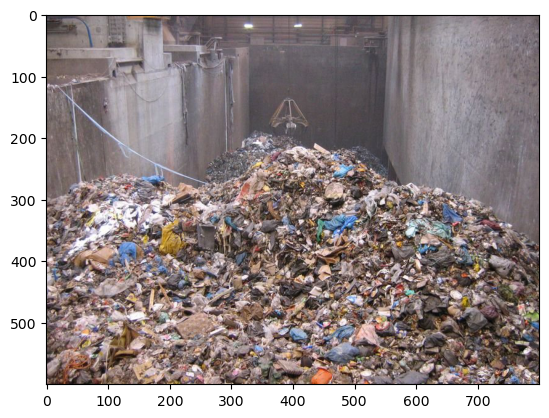

In [25]:
def evaluate_image1(model, image_path, transform):
    model.load_state_dict(torch.load('inceptionv3_model.pth'))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # Preprocess
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    print(image_tensor)
    plt.imshow(image)
    with torch.no_grad():
        outputs = model(image_tensor)

    _, predicted_idx = torch.max(outputs, 1)
    predicted_idx = predicted_idx.item()  # Extract the index value from the tensor
    print(predicted_idx)
    
    class_names = ['garbage', 'nongarbarge']  
    predicted_class = class_names[predicted_idx]

    return predicted_class

#input 
image_path = r"C:\Users\Dell\Downloads\abcd.jpg"
predicted_class = evaluate_image1(modeli, image_path, transform)
print(f"Predicted Class: {predicted_class}")

# HEATMAP

features 1920
features 2048


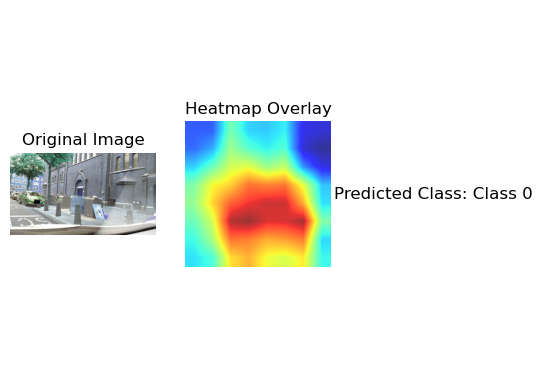

In [17]:
import cv2
modeli = Inceptionv3Net(num_classes=2)

modeli.load_state_dict(torch.load('inceptionv3_model.pth'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modeli.to(device)
modeli.eval()

transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the image
img_path = r"C:\Users\Dell\Downloads\base\30.jpg"
orgimg = cv2.imread(img_path)
img = cv2.cvtColor(orgimg, cv2.COLOR_BGR2RGB)
# Convert the NumPy array to a PIL Image
img = Image.fromarray(img)

img = transform(img)
img = img.unsqueeze(0)
img = img.to(device)

# Hook to the last convolutional layer before global average pooling
hook_layer = modeli.inception.Mixed_7c.branch3x3dbl_3b.conv

#hook function to capture feature maps
def hook_fn(module, input, output):
    global feature_maps
    feature_maps = output

# Register the hook
hook_handle = hook_layer.register_forward_hook(hook_fn)
output = modeli(img)

# Remove the hook
hook_handle.remove()

heatmap = torch.mean(feature_maps, dim=1).squeeze()

#softmax probabilities
probabilities = nn.functional.softmax(output, dim=1)

#get predictions
predicted_class = torch.argmax(probabilities, dim=1).item()
class_labels = ['Class 0', 'Class 1']  # Define your class labels
predicted_label = class_labels[predicted_class]

# Visualize image
plt.subplot(1, 3, 1)
plt.imshow(orgimg)
plt.title('Original Image')
plt.axis('off')

# Visualize the heatmap 
plt.subplot(1, 3, 2)
plt.imshow(orgimg)
plt.imshow(heatmap.detach().cpu().numpy(), alpha=0.8, cmap='jet', interpolation='bilinear')  # Overlay the heatmap
plt.title('Heatmap Overlay')
plt.axis('off')

# Show predicted class
plt.subplot(1, 3, 3)
plt.text(0.5, 0.5, 'Predicted Class: ' + predicted_label, horizontalalignment='center', verticalalignment='center', fontsize=12)
plt.axis('off')

plt.show()
